<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[02:57:22] /work/mxnet/src/storage/storage.cc:205: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


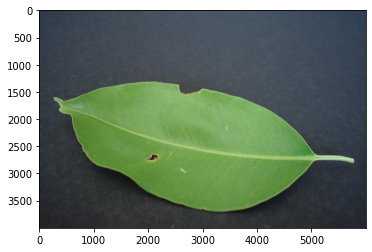

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

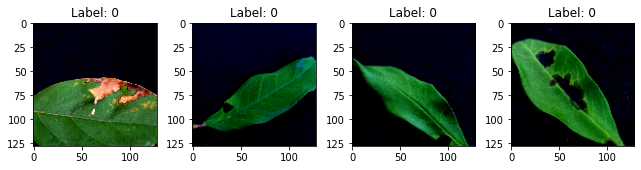

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[02:57:27] /work/mxnet/src/storage/storage.cc:205: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[02:57:29] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:107: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2438316877259776 samples/sec                   batch loss = 1.6461445093154907 | accuracy = 0.6


Epoch[1] Batch[10] Speed: 1.2657074864460822 samples/sec                   batch loss = 0.6752645373344421 | accuracy = 0.55


Epoch[1] Batch[15] Speed: 1.2237011753929896 samples/sec                   batch loss = 0.8169864416122437 | accuracy = 0.5


Epoch[1] Batch[20] Speed: 1.2669148359050384 samples/sec                   batch loss = 0.6668716669082642 | accuracy = 0.475


Epoch[1] Batch[25] Speed: 1.2586059458819163 samples/sec                   batch loss = 0.4898573160171509 | accuracy = 0.5


Epoch[1] Batch[30] Speed: 1.256457525886721 samples/sec                   batch loss = 0.6065351366996765 | accuracy = 0.49166666666666664


Epoch[1] Batch[35] Speed: 1.2611713369822664 samples/sec                   batch loss = 0.721872866153717 | accuracy = 0.5071428571428571


Epoch[1] Batch[40] Speed: 1.2545604821302772 samples/sec                   batch loss = 0.9524539113044739 | accuracy = 0.51875


Epoch[1] Batch[45] Speed: 1.2584787762616019 samples/sec                   batch loss = 0.9345710277557373 | accuracy = 0.5277777777777778


Epoch[1] Batch[50] Speed: 1.2634635988676344 samples/sec                   batch loss = 0.7381009459495544 | accuracy = 0.52


Epoch[1] Batch[55] Speed: 1.2616415522240085 samples/sec                   batch loss = 0.63173508644104 | accuracy = 0.5181818181818182


Epoch[1] Batch[60] Speed: 1.2625957677509934 samples/sec                   batch loss = 0.6440011262893677 | accuracy = 0.5166666666666667


Epoch[1] Batch[65] Speed: 1.2601613424402485 samples/sec                   batch loss = 0.39961934089660645 | accuracy = 0.5346153846153846


Epoch[1] Batch[70] Speed: 1.256710321251382 samples/sec                   batch loss = 0.6990998387336731 | accuracy = 0.5214285714285715


Epoch[1] Batch[75] Speed: 1.2541555280844767 samples/sec                   batch loss = 0.345669150352478 | accuracy = 0.5333333333333333


Epoch[1] Batch[80] Speed: 1.2597108626494344 samples/sec                   batch loss = 1.0764816999435425 | accuracy = 0.54375


Epoch[1] Batch[85] Speed: 1.2599873004047573 samples/sec                   batch loss = 0.5185413956642151 | accuracy = 0.5470588235294118


Epoch[1] Batch[90] Speed: 1.2630799782756352 samples/sec                   batch loss = 0.8670622110366821 | accuracy = 0.5555555555555556


Epoch[1] Batch[95] Speed: 1.2559610782096515 samples/sec                   batch loss = 0.6444783210754395 | accuracy = 0.55


Epoch[1] Batch[100] Speed: 1.2570497690743065 samples/sec                   batch loss = 0.618209958076477 | accuracy = 0.5525


Epoch[1] Batch[105] Speed: 1.2605045514545128 samples/sec                   batch loss = 0.36886778473854065 | accuracy = 0.5523809523809524


Epoch[1] Batch[110] Speed: 1.2619687662802557 samples/sec                   batch loss = 0.6456409692764282 | accuracy = 0.5545454545454546


Epoch[1] Batch[115] Speed: 1.2575551843894566 samples/sec                   batch loss = 0.6364203691482544 | accuracy = 0.5543478260869565


Epoch[1] Batch[120] Speed: 1.2567235002695887 samples/sec                   batch loss = 0.7054685354232788 | accuracy = 0.5583333333333333


Epoch[1] Batch[125] Speed: 1.2605588192599668 samples/sec                   batch loss = 0.4838000535964966 | accuracy = 0.56


Epoch[1] Batch[130] Speed: 1.26080843556181 samples/sec                   batch loss = 0.4533236622810364 | accuracy = 0.5692307692307692


Epoch[1] Batch[135] Speed: 1.2604889254659963 samples/sec                   batch loss = 0.34614357352256775 | accuracy = 0.5796296296296296


Epoch[1] Batch[140] Speed: 1.2579860125933449 samples/sec                   batch loss = 0.3465430438518524 | accuracy = 0.5875


Epoch[1] Batch[145] Speed: 1.2527839305218278 samples/sec                   batch loss = 0.31111541390419006 | accuracy = 0.5896551724137931


Epoch[1] Batch[150] Speed: 1.2503370247250833 samples/sec                   batch loss = 0.5398608446121216 | accuracy = 0.5916666666666667


Epoch[1] Batch[155] Speed: 1.25235086154091 samples/sec                   batch loss = 0.5620637536048889 | accuracy = 0.5903225806451613


Epoch[1] Batch[160] Speed: 1.257519554563331 samples/sec                   batch loss = 0.3336598873138428 | accuracy = 0.59375


Epoch[1] Batch[165] Speed: 1.2533721529798079 samples/sec                   batch loss = 0.7595343589782715 | accuracy = 0.593939393939394


Epoch[1] Batch[170] Speed: 1.2582097938263395 samples/sec                   batch loss = 0.44161731004714966 | accuracy = 0.6


Epoch[1] Batch[175] Speed: 1.2604739627613137 samples/sec                   batch loss = 0.890926718711853 | accuracy = 0.6028571428571429


Epoch[1] Batch[180] Speed: 1.2580243101426032 samples/sec                   batch loss = 0.37281930446624756 | accuracy = 0.6069444444444444


Epoch[1] Batch[185] Speed: 1.2520379590155946 samples/sec                   batch loss = 0.8761200308799744 | accuracy = 0.6081081081081081


Epoch[1] Batch[190] Speed: 1.2522080359716514 samples/sec                   batch loss = 0.5372018218040466 | accuracy = 0.6092105263157894


Epoch[1] Batch[195] Speed: 1.2566653264007028 samples/sec                   batch loss = 0.8359264135360718 | accuracy = 0.6051282051282051


Epoch[1] Batch[200] Speed: 1.2586288901312221 samples/sec                   batch loss = 0.35198333859443665 | accuracy = 0.6075


Epoch[1] Batch[205] Speed: 1.268367236160785 samples/sec                   batch loss = 0.22456972301006317 | accuracy = 0.6109756097560975


Epoch[1] Batch[210] Speed: 1.260932854329821 samples/sec                   batch loss = 0.3433617949485779 | accuracy = 0.6130952380952381


Epoch[1] Batch[215] Speed: 1.25910174674947 samples/sec                   batch loss = 0.6808279752731323 | accuracy = 0.6162790697674418


Epoch[1] Batch[220] Speed: 1.2555891407793145 samples/sec                   batch loss = 0.8009729981422424 | accuracy = 0.615909090909091


Epoch[1] Batch[225] Speed: 1.2542191892691592 samples/sec                   batch loss = 0.4452826678752899 | accuracy = 0.62


Epoch[1] Batch[230] Speed: 1.2540512839602127 samples/sec                   batch loss = 0.5483482480049133 | accuracy = 0.6239130434782608


Epoch[1] Batch[235] Speed: 1.2539844530950677 samples/sec                   batch loss = 0.7385175228118896 | accuracy = 0.625531914893617


Epoch[1] Batch[240] Speed: 1.256461666167893 samples/sec                   batch loss = 0.31163421273231506 | accuracy = 0.6270833333333333


Epoch[1] Batch[245] Speed: 1.2588607400703262 samples/sec                   batch loss = 0.6083554625511169 | accuracy = 0.6275510204081632


Epoch[1] Batch[250] Speed: 1.2565938872216824 samples/sec                   batch loss = 0.5583553910255432 | accuracy = 0.63


Epoch[1] Batch[255] Speed: 1.2519066015228935 samples/sec                   batch loss = 0.4549916088581085 | accuracy = 0.6313725490196078


Epoch[1] Batch[260] Speed: 1.2519872252232367 samples/sec                   batch loss = 0.4753302037715912 | accuracy = 0.6317307692307692


Epoch[1] Batch[265] Speed: 1.255632367071916 samples/sec                   batch loss = 0.5703124403953552 | accuracy = 0.6311320754716981


Epoch[1] Batch[270] Speed: 1.2527476351211346 samples/sec                   batch loss = 0.6717698574066162 | accuracy = 0.6324074074074074


Epoch[1] Batch[275] Speed: 1.260109096387904 samples/sec                   batch loss = 0.4694582223892212 | accuracy = 0.6309090909090909


Epoch[1] Batch[280] Speed: 1.251851581575507 samples/sec                   batch loss = 0.5200529098510742 | accuracy = 0.6330357142857143


Epoch[1] Batch[285] Speed: 1.251182761538166 samples/sec                   batch loss = 0.4563967287540436 | accuracy = 0.6324561403508772


Epoch[1] Batch[290] Speed: 1.2596756780458482 samples/sec                   batch loss = 0.44602862000465393 | accuracy = 0.6301724137931034


Epoch[1] Batch[295] Speed: 1.261435327553928 samples/sec                   batch loss = 0.4426475465297699 | accuracy = 0.6305084745762712


Epoch[1] Batch[300] Speed: 1.257463380420085 samples/sec                   batch loss = 0.37472331523895264 | accuracy = 0.6316666666666667


Epoch[1] Batch[305] Speed: 1.258390424084939 samples/sec                   batch loss = 0.4190850555896759 | accuracy = 0.6303278688524591


Epoch[1] Batch[310] Speed: 1.25742832125025 samples/sec                   batch loss = 0.18660853803157806 | accuracy = 0.6314516129032258


Epoch[1] Batch[315] Speed: 1.2629572270492642 samples/sec                   batch loss = 0.6388716697692871 | accuracy = 0.6325396825396825


Epoch[1] Batch[320] Speed: 1.2624649406554305 samples/sec                   batch loss = 0.2727707624435425 | accuracy = 0.6328125


Epoch[1] Batch[325] Speed: 1.2576981953009156 samples/sec                   batch loss = 0.1934267282485962 | accuracy = 0.6353846153846154


Epoch[1] Batch[330] Speed: 1.2530337523079103 samples/sec                   batch loss = 0.4655974805355072 | accuracy = 0.6363636363636364


Epoch[1] Batch[335] Speed: 1.2576462475630934 samples/sec                   batch loss = 0.5489643216133118 | accuracy = 0.6373134328358209


Epoch[1] Batch[340] Speed: 1.245737375033404 samples/sec                   batch loss = 0.6748807430267334 | accuracy = 0.6367647058823529


Epoch[1] Batch[345] Speed: 1.2495576666008268 samples/sec                   batch loss = 1.1198999881744385 | accuracy = 0.6384057971014493


Epoch[1] Batch[350] Speed: 1.2499184028428367 samples/sec                   batch loss = 0.21025536954402924 | accuracy = 0.6392857142857142


Epoch[1] Batch[355] Speed: 1.2555709114525198 samples/sec                   batch loss = 0.5123541355133057 | accuracy = 0.6415492957746479


Epoch[1] Batch[360] Speed: 1.257240618308326 samples/sec                   batch loss = 0.9341199398040771 | accuracy = 0.6416666666666667


Epoch[1] Batch[365] Speed: 1.2559397354318445 samples/sec                   batch loss = 0.9154659509658813 | accuracy = 0.6424657534246575


Epoch[1] Batch[370] Speed: 1.2552950930542754 samples/sec                   batch loss = 0.3736891746520996 | accuracy = 0.643918918918919


Epoch[1] Batch[375] Speed: 1.2597412251371942 samples/sec                   batch loss = 0.509690523147583 | accuracy = 0.6446666666666667


Epoch[1] Batch[380] Speed: 1.256430050166688 samples/sec                   batch loss = 0.5691536068916321 | accuracy = 0.6453947368421052


Epoch[1] Batch[385] Speed: 1.2629130196322973 samples/sec                   batch loss = 0.6379104256629944 | accuracy = 0.6461038961038961


Epoch[1] Batch[390] Speed: 1.2599293916933145 samples/sec                   batch loss = 0.8374918103218079 | accuracy = 0.6474358974358975


Epoch[1] Batch[395] Speed: 1.2628745189196522 samples/sec                   batch loss = 0.4883168339729309 | accuracy = 0.649367088607595


Epoch[1] Batch[400] Speed: 1.2584884051330845 samples/sec                   batch loss = 0.2946719229221344 | accuracy = 0.65125


Epoch[1] Batch[405] Speed: 1.2602772078379714 samples/sec                   batch loss = 0.7895990014076233 | accuracy = 0.6512345679012346


Epoch[1] Batch[410] Speed: 1.2633380142829078 samples/sec                   batch loss = 0.5348352789878845 | accuracy = 0.651829268292683


Epoch[1] Batch[415] Speed: 1.268292542797424 samples/sec                   batch loss = 0.455084890127182 | accuracy = 0.653012048192771


Epoch[1] Batch[420] Speed: 1.2644080902385515 samples/sec                   batch loss = 0.4264281690120697 | accuracy = 0.6535714285714286


Epoch[1] Batch[425] Speed: 1.2557145052281344 samples/sec                   batch loss = 0.4631921648979187 | accuracy = 0.6535294117647059


Epoch[1] Batch[430] Speed: 1.2584731122883812 samples/sec                   batch loss = 0.4505259394645691 | accuracy = 0.6540697674418605


Epoch[1] Batch[435] Speed: 1.258461406905284 samples/sec                   batch loss = 0.3745976686477661 | accuracy = 0.6557471264367816


Epoch[1] Batch[440] Speed: 1.2560113823396308 samples/sec                   batch loss = 0.10769011825323105 | accuracy = 0.6568181818181819


Epoch[1] Batch[445] Speed: 1.2532472557697036 samples/sec                   batch loss = 0.5624728202819824 | accuracy = 0.6556179775280899


Epoch[1] Batch[450] Speed: 1.2588515777798488 samples/sec                   batch loss = 0.3645593523979187 | accuracy = 0.6566666666666666


Epoch[1] Batch[455] Speed: 1.2521807457876681 samples/sec                   batch loss = 0.5401171445846558 | accuracy = 0.6576923076923077


Epoch[1] Batch[460] Speed: 1.2597495490654755 samples/sec                   batch loss = 0.5366700291633606 | accuracy = 0.6592391304347827


Epoch[1] Batch[465] Speed: 1.2548577523323996 samples/sec                   batch loss = 0.4871298372745514 | accuracy = 0.6580645161290323


Epoch[1] Batch[470] Speed: 1.25485578132746 samples/sec                   batch loss = 0.6743046045303345 | accuracy = 0.6585106382978724


Epoch[1] Batch[475] Speed: 1.2603572090459985 samples/sec                   batch loss = 0.23623982071876526 | accuracy = 0.6589473684210526


Epoch[1] Batch[480] Speed: 1.2564084091784258 samples/sec                   batch loss = 0.1618981510400772 | accuracy = 0.6604166666666667


Epoch[1] Batch[485] Speed: 1.2649944053539708 samples/sec                   batch loss = 0.6032482385635376 | accuracy = 0.6608247422680412


Epoch[1] Batch[490] Speed: 1.2551974207772039 samples/sec                   batch loss = 0.34664586186408997 | accuracy = 0.6612244897959184


Epoch[1] Batch[495] Speed: 1.2631668028046354 samples/sec                   batch loss = 0.25312888622283936 | accuracy = 0.6636363636363637


Epoch[1] Batch[500] Speed: 1.2536249259599686 samples/sec                   batch loss = 0.30376046895980835 | accuracy = 0.6635


Epoch[1] Batch[505] Speed: 1.258172617230826 samples/sec                   batch loss = 0.45950910449028015 | accuracy = 0.6648514851485149


Epoch[1] Batch[510] Speed: 1.2609279263868676 samples/sec                   batch loss = 0.7360605001449585 | accuracy = 0.6661764705882353


Epoch[1] Batch[515] Speed: 1.2541253405033166 samples/sec                   batch loss = 0.3690667748451233 | accuracy = 0.6669902912621359


Epoch[1] Batch[520] Speed: 1.2539802353972456 samples/sec                   batch loss = 1.428061604499817 | accuracy = 0.6677884615384615


Epoch[1] Batch[525] Speed: 1.2534693540886916 samples/sec                   batch loss = 0.11596708744764328 | accuracy = 0.6680952380952381


Epoch[1] Batch[530] Speed: 1.2568428771105618 samples/sec                   batch loss = 0.3612403869628906 | accuracy = 0.6693396226415095


Epoch[1] Batch[535] Speed: 1.2558644303679785 samples/sec                   batch loss = 0.28215351700782776 | accuracy = 0.6700934579439253


Epoch[1] Batch[540] Speed: 1.252712370728199 samples/sec                   batch loss = 0.445012629032135 | accuracy = 0.6699074074074074


Epoch[1] Batch[545] Speed: 1.2551807992204917 samples/sec                   batch loss = 0.4471724033355713 | accuracy = 0.6706422018348623


Epoch[1] Batch[550] Speed: 1.2488454636721062 samples/sec                   batch loss = 0.446188747882843 | accuracy = 0.6722727272727272


Epoch[1] Batch[555] Speed: 1.2549970523620337 samples/sec                   batch loss = 0.7120349407196045 | accuracy = 0.672972972972973


Epoch[1] Batch[560] Speed: 1.2530893441871767 samples/sec                   batch loss = 0.5213622450828552 | accuracy = 0.6727678571428571


Epoch[1] Batch[565] Speed: 1.2573140155471167 samples/sec                   batch loss = 0.47536200284957886 | accuracy = 0.6730088495575222


Epoch[1] Batch[570] Speed: 1.2538307597636786 samples/sec                   batch loss = 0.42376720905303955 | accuracy = 0.6736842105263158


Epoch[1] Batch[575] Speed: 1.2583528592901052 samples/sec                   batch loss = 0.4428730607032776 | accuracy = 0.6739130434782609


Epoch[1] Batch[580] Speed: 1.2552803473229286 samples/sec                   batch loss = 0.8605285286903381 | accuracy = 0.6737068965517241


Epoch[1] Batch[585] Speed: 1.2567397861524894 samples/sec                   batch loss = 0.13040058314800262 | accuracy = 0.6747863247863248


Epoch[1] Batch[590] Speed: 1.2509278011377727 samples/sec                   batch loss = 0.368956983089447 | accuracy = 0.6758474576271186


Epoch[1] Batch[595] Speed: 1.2604239633884495 samples/sec                   batch loss = 0.2736901342868805 | accuracy = 0.6756302521008404


Epoch[1] Batch[600] Speed: 1.262884500360486 samples/sec                   batch loss = 0.45966005325317383 | accuracy = 0.6770833333333334


Epoch[1] Batch[605] Speed: 1.2577834328281672 samples/sec                   batch loss = 0.8878447413444519 | accuracy = 0.678099173553719


Epoch[1] Batch[610] Speed: 1.2524253718390888 samples/sec                   batch loss = 0.2554820477962494 | accuracy = 0.6795081967213115


Epoch[1] Batch[615] Speed: 1.2536439419073495 samples/sec                   batch loss = 0.5376042127609253 | accuracy = 0.6796747967479675


Epoch[1] Batch[620] Speed: 1.254146246654806 samples/sec                   batch loss = 0.5784040689468384 | accuracy = 0.6806451612903226


Epoch[1] Batch[625] Speed: 1.2604567276809924 samples/sec                   batch loss = 0.7859652042388916 | accuracy = 0.68


Epoch[1] Batch[630] Speed: 1.2556434560353447 samples/sec                   batch loss = 0.3816506266593933 | accuracy = 0.6801587301587302


Epoch[1] Batch[635] Speed: 1.2564298619809684 samples/sec                   batch loss = 0.49634450674057007 | accuracy = 0.6791338582677166


Epoch[1] Batch[640] Speed: 1.2554136350218257 samples/sec                   batch loss = 0.9319576025009155 | accuracy = 0.67890625


Epoch[1] Batch[645] Speed: 1.2581438399027514 samples/sec                   batch loss = 0.46771860122680664 | accuracy = 0.6790697674418604


Epoch[1] Batch[650] Speed: 1.2515587214586257 samples/sec                   batch loss = 0.4742206633090973 | accuracy = 0.6796153846153846


Epoch[1] Batch[655] Speed: 1.2533258987867764 samples/sec                   batch loss = 0.6596372723579407 | accuracy = 0.6801526717557251


Epoch[1] Batch[660] Speed: 1.2582096051071088 samples/sec                   batch loss = 0.42348966002464294 | accuracy = 0.6795454545454546


Epoch[1] Batch[665] Speed: 1.2498202619649734 samples/sec                   batch loss = 0.36592647433280945 | accuracy = 0.6789473684210526


Epoch[1] Batch[670] Speed: 1.2613129905972233 samples/sec                   batch loss = 0.37973979115486145 | accuracy = 0.6783582089552239


Epoch[1] Batch[675] Speed: 1.250327706546045 samples/sec                   batch loss = 0.37092897295951843 | accuracy = 0.68


Epoch[1] Batch[680] Speed: 1.2552274721666226 samples/sec                   batch loss = 0.5524280071258545 | accuracy = 0.6801470588235294


Epoch[1] Batch[685] Speed: 1.2526850585574378 samples/sec                   batch loss = 0.3928868770599365 | accuracy = 0.6802919708029197


Epoch[1] Batch[690] Speed: 1.259806306053976 samples/sec                   batch loss = 0.3677341639995575 | accuracy = 0.6807971014492754


Epoch[1] Batch[695] Speed: 1.2585483528922048 samples/sec                   batch loss = 0.6816871166229248 | accuracy = 0.6798561151079137


Epoch[1] Batch[700] Speed: 1.2610798574156998 samples/sec                   batch loss = 0.7818999886512756 | accuracy = 0.6810714285714285


Epoch[1] Batch[705] Speed: 1.2573249457791686 samples/sec                   batch loss = 0.19341246783733368 | accuracy = 0.6815602836879433


Epoch[1] Batch[710] Speed: 1.2510922587565823 samples/sec                   batch loss = 0.7216655015945435 | accuracy = 0.6816901408450704


Epoch[1] Batch[715] Speed: 1.2536220220975964 samples/sec                   batch loss = 1.0746996402740479 | accuracy = 0.6814685314685315


Epoch[1] Batch[720] Speed: 1.2584817970681659 samples/sec                   batch loss = 0.3565215766429901 | accuracy = 0.6826388888888889


Epoch[1] Batch[725] Speed: 1.2568907095269097 samples/sec                   batch loss = 0.9009276628494263 | accuracy = 0.6813793103448276


Epoch[1] Batch[730] Speed: 1.2558426208499978 samples/sec                   batch loss = 0.6833166480064392 | accuracy = 0.6801369863013699


Epoch[1] Batch[735] Speed: 1.2575337873998491 samples/sec                   batch loss = 0.3336879014968872 | accuracy = 0.6802721088435374


Epoch[1] Batch[740] Speed: 1.263136370066711 samples/sec                   batch loss = 0.4408870041370392 | accuracy = 0.6817567567567567


Epoch[1] Batch[745] Speed: 1.2582664121516807 samples/sec                   batch loss = 0.43809428811073303 | accuracy = 0.6815436241610738


Epoch[1] Batch[750] Speed: 1.2565304552862688 samples/sec                   batch loss = 0.47584599256515503 | accuracy = 0.6823333333333333


Epoch[1] Batch[755] Speed: 1.257134447737914 samples/sec                   batch loss = 0.3799445927143097 | accuracy = 0.6824503311258279


Epoch[1] Batch[760] Speed: 1.2559039150430904 samples/sec                   batch loss = 0.7094493508338928 | accuracy = 0.6835526315789474


Epoch[1] Batch[765] Speed: 1.2550227755611754 samples/sec                   batch loss = 0.643867015838623 | accuracy = 0.6843137254901961


Epoch[1] Batch[770] Speed: 1.2561743577809854 samples/sec                   batch loss = 0.547378420829773 | accuracy = 0.6837662337662338


Epoch[1] Batch[775] Speed: 1.2528705615501612 samples/sec                   batch loss = 0.3258136808872223 | accuracy = 0.6835483870967742


Epoch[1] Batch[780] Speed: 1.2555239310915793 samples/sec                   batch loss = 0.3632960617542267 | accuracy = 0.6846153846153846


Epoch[1] Batch[785] Speed: 1.2526825331771427 samples/sec                   batch loss = 0.5503905415534973 | accuracy = 0.6847133757961783


[Epoch 1] training: accuracy=0.684010152284264
[Epoch 1] time cost: 653.7120819091797
[Epoch 1] validation: validation accuracy=0.7133333333333334


Epoch[2] Batch[5] Speed: 1.2714527704990986 samples/sec                   batch loss = 0.34247392416000366 | accuracy = 0.85


Epoch[2] Batch[10] Speed: 1.2763351326711112 samples/sec                   batch loss = 0.4615328311920166 | accuracy = 0.725


Epoch[2] Batch[15] Speed: 1.265641412503112 samples/sec                   batch loss = 0.42778196930885315 | accuracy = 0.6833333333333333


Epoch[2] Batch[20] Speed: 1.2739931657680916 samples/sec                   batch loss = 0.4313112497329712 | accuracy = 0.7


Epoch[2] Batch[25] Speed: 1.2727078941237793 samples/sec                   batch loss = 0.4344300925731659 | accuracy = 0.72


Epoch[2] Batch[30] Speed: 1.2714679949927072 samples/sec                   batch loss = 1.1013249158859253 | accuracy = 0.7083333333333334


Epoch[2] Batch[35] Speed: 1.2752002921134091 samples/sec                   batch loss = 0.2950388193130493 | accuracy = 0.7357142857142858


Epoch[2] Batch[40] Speed: 1.2815755698190356 samples/sec                   batch loss = 0.32718154788017273 | accuracy = 0.75625


Epoch[2] Batch[45] Speed: 1.268479244750059 samples/sec                   batch loss = 0.5074545741081238 | accuracy = 0.75


Epoch[2] Batch[50] Speed: 1.2627615970367898 samples/sec                   batch loss = 0.5805928111076355 | accuracy = 0.755


Epoch[2] Batch[55] Speed: 1.2624248523759987 samples/sec                   batch loss = 0.5510385632514954 | accuracy = 0.7636363636363637


Epoch[2] Batch[60] Speed: 1.2729813732224529 samples/sec                   batch loss = 0.2723308205604553 | accuracy = 0.7625


Epoch[2] Batch[65] Speed: 1.278948813204601 samples/sec                   batch loss = 0.6529707908630371 | accuracy = 0.7576923076923077


Epoch[2] Batch[70] Speed: 1.2664807393911806 samples/sec                   batch loss = 0.38181963562965393 | accuracy = 0.7571428571428571


Epoch[2] Batch[75] Speed: 1.2756896615569022 samples/sec                   batch loss = 0.32117995619773865 | accuracy = 0.7633333333333333


Epoch[2] Batch[80] Speed: 1.2984661316531891 samples/sec                   batch loss = 0.46406063437461853 | accuracy = 0.765625


Epoch[2] Batch[85] Speed: 1.2990188844268247 samples/sec                   batch loss = 0.43874573707580566 | accuracy = 0.7617647058823529


Epoch[2] Batch[90] Speed: 1.293838939678052 samples/sec                   batch loss = 0.6692354679107666 | accuracy = 0.7611111111111111


Epoch[2] Batch[95] Speed: 1.2889254785257653 samples/sec                   batch loss = 0.8585140109062195 | accuracy = 0.7473684210526316


Epoch[2] Batch[100] Speed: 1.2949132569022495 samples/sec                   batch loss = 0.6951184868812561 | accuracy = 0.745


Epoch[2] Batch[105] Speed: 1.2968939954898013 samples/sec                   batch loss = 0.444938063621521 | accuracy = 0.7404761904761905


Epoch[2] Batch[110] Speed: 1.292377229402902 samples/sec                   batch loss = 1.206668496131897 | accuracy = 0.7386363636363636


Epoch[2] Batch[115] Speed: 1.3074887662388723 samples/sec                   batch loss = 0.31187769770622253 | accuracy = 0.7369565217391304


Epoch[2] Batch[120] Speed: 1.2970628402890658 samples/sec                   batch loss = 0.467239648103714 | accuracy = 0.7395833333333334


Epoch[2] Batch[125] Speed: 1.2966321925275779 samples/sec                   batch loss = 0.51925128698349 | accuracy = 0.738


Epoch[2] Batch[130] Speed: 1.2967935516868418 samples/sec                   batch loss = 0.27807703614234924 | accuracy = 0.7365384615384616


Epoch[2] Batch[135] Speed: 1.3000279808106345 samples/sec                   batch loss = 0.3961936831474304 | accuracy = 0.737037037037037


Epoch[2] Batch[140] Speed: 1.2971594144093017 samples/sec                   batch loss = 0.6894285678863525 | accuracy = 0.7375


Epoch[2] Batch[145] Speed: 1.3036207664728316 samples/sec                   batch loss = 0.3628208041191101 | accuracy = 0.7396551724137931


Epoch[2] Batch[150] Speed: 1.3042484820630633 samples/sec                   batch loss = 0.3313216269016266 | accuracy = 0.7416666666666667


Epoch[2] Batch[155] Speed: 1.2994083458009715 samples/sec                   batch loss = 0.3643447458744049 | accuracy = 0.7403225806451613


Epoch[2] Batch[160] Speed: 1.3112260513041751 samples/sec                   batch loss = 1.414078712463379 | accuracy = 0.740625


Epoch[2] Batch[165] Speed: 1.3027417247031656 samples/sec                   batch loss = 0.351521372795105 | accuracy = 0.7393939393939394


Epoch[2] Batch[170] Speed: 1.3015894516831188 samples/sec                   batch loss = 0.4091448187828064 | accuracy = 0.7441176470588236


Epoch[2] Batch[175] Speed: 1.300911331825432 samples/sec                   batch loss = 0.39071181416511536 | accuracy = 0.7471428571428571


Epoch[2] Batch[180] Speed: 1.3029273745966992 samples/sec                   batch loss = 0.5268704295158386 | accuracy = 0.7472222222222222


Epoch[2] Batch[185] Speed: 1.3005821652379337 samples/sec                   batch loss = 0.6584305763244629 | accuracy = 0.7486486486486487


Epoch[2] Batch[190] Speed: 1.3026598936781706 samples/sec                   batch loss = 0.6662176847457886 | accuracy = 0.7473684210526316


Epoch[2] Batch[195] Speed: 1.2953640661971388 samples/sec                   batch loss = 0.4546666145324707 | accuracy = 0.7448717948717949


Epoch[2] Batch[200] Speed: 1.3019672202135473 samples/sec                   batch loss = 0.31507688760757446 | accuracy = 0.745


Epoch[2] Batch[205] Speed: 1.2918250403088576 samples/sec                   batch loss = 0.5734851360321045 | accuracy = 0.7439024390243902


Epoch[2] Batch[210] Speed: 1.2967357183523498 samples/sec                   batch loss = 0.7538965344429016 | accuracy = 0.7428571428571429


Epoch[2] Batch[215] Speed: 1.2962217596186651 samples/sec                   batch loss = 0.41358786821365356 | accuracy = 0.7453488372093023


Epoch[2] Batch[220] Speed: 1.2978807150265994 samples/sec                   batch loss = 0.3450927734375 | accuracy = 0.7454545454545455


Epoch[2] Batch[225] Speed: 1.2989208264644143 samples/sec                   batch loss = 0.34245792031288147 | accuracy = 0.7488888888888889


Epoch[2] Batch[230] Speed: 1.2980311371819508 samples/sec                   batch loss = 0.1886628270149231 | accuracy = 0.7510869565217392


Epoch[2] Batch[235] Speed: 1.2997997526871699 samples/sec                   batch loss = 0.6468990445137024 | accuracy = 0.7531914893617021


Epoch[2] Batch[240] Speed: 1.2923607036508007 samples/sec                   batch loss = 0.21432507038116455 | accuracy = 0.7552083333333334


Epoch[2] Batch[245] Speed: 1.2973763825479643 samples/sec                   batch loss = 0.20543110370635986 | accuracy = 0.7551020408163265


Epoch[2] Batch[250] Speed: 1.2988246937481716 samples/sec                   batch loss = 0.8019564747810364 | accuracy = 0.754


Epoch[2] Batch[255] Speed: 1.2950610925645292 samples/sec                   batch loss = 0.7227268815040588 | accuracy = 0.7549019607843137


Epoch[2] Batch[260] Speed: 1.2958886555782085 samples/sec                   batch loss = 0.13873440027236938 | accuracy = 0.7557692307692307


Epoch[2] Batch[265] Speed: 1.294581923788634 samples/sec                   batch loss = 0.6004745960235596 | accuracy = 0.7594339622641509


Epoch[2] Batch[270] Speed: 1.2951804652522925 samples/sec                   batch loss = 0.3700965344905853 | accuracy = 0.7583333333333333


Epoch[2] Batch[275] Speed: 1.2892019107636639 samples/sec                   batch loss = 0.22371774911880493 | accuracy = 0.76


Epoch[2] Batch[280] Speed: 1.3026107393154414 samples/sec                   batch loss = 0.33793798089027405 | accuracy = 0.7607142857142857


Epoch[2] Batch[285] Speed: 1.2995466401261095 samples/sec                   batch loss = 0.38290637731552124 | accuracy = 0.762280701754386


Epoch[2] Batch[290] Speed: 1.2918142977523936 samples/sec                   batch loss = 0.4484243094921112 | accuracy = 0.7603448275862069


Epoch[2] Batch[295] Speed: 1.2976763253113626 samples/sec                   batch loss = 0.25731709599494934 | accuracy = 0.7610169491525424


Epoch[2] Batch[300] Speed: 1.2992450273173262 samples/sec                   batch loss = 0.5394980311393738 | accuracy = 0.7608333333333334


Epoch[2] Batch[305] Speed: 1.2978661566552323 samples/sec                   batch loss = 0.39814499020576477 | accuracy = 0.759016393442623


Epoch[2] Batch[310] Speed: 1.2969415162432547 samples/sec                   batch loss = 0.6002904772758484 | accuracy = 0.7564516129032258


Epoch[2] Batch[315] Speed: 1.2949715275110563 samples/sec                   batch loss = 0.3400336503982544 | accuracy = 0.7555555555555555


Epoch[2] Batch[320] Speed: 1.2909611338520246 samples/sec                   batch loss = 0.7955342531204224 | accuracy = 0.75546875


Epoch[2] Batch[325] Speed: 1.3023270111347254 samples/sec                   batch loss = 0.2790665030479431 | accuracy = 0.7561538461538462


Epoch[2] Batch[330] Speed: 1.2982212732680747 samples/sec                   batch loss = 0.579581618309021 | accuracy = 0.7575757575757576


Epoch[2] Batch[335] Speed: 1.2988025731706005 samples/sec                   batch loss = 1.2880678176879883 | accuracy = 0.7559701492537313


Epoch[2] Batch[340] Speed: 1.287299101403596 samples/sec                   batch loss = 0.3672768473625183 | accuracy = 0.7551470588235294


Epoch[2] Batch[345] Speed: 1.2900295387356042 samples/sec                   batch loss = 0.38140448927879333 | accuracy = 0.7572463768115942


Epoch[2] Batch[350] Speed: 1.2943091708921275 samples/sec                   batch loss = 0.18150344491004944 | accuracy = 0.76


Epoch[2] Batch[355] Speed: 1.298323746869054 samples/sec                   batch loss = 0.8190386891365051 | accuracy = 0.7598591549295775


Epoch[2] Batch[360] Speed: 1.3052322123459514 samples/sec                   batch loss = 0.6152568459510803 | accuracy = 0.7576388888888889


Epoch[2] Batch[365] Speed: 1.2934932966962647 samples/sec                   batch loss = 0.38675135374069214 | accuracy = 0.7568493150684932


Epoch[2] Batch[370] Speed: 1.2919745594332603 samples/sec                   batch loss = 0.39672788977622986 | accuracy = 0.7574324324324324


Epoch[2] Batch[375] Speed: 1.2961724890795958 samples/sec                   batch loss = 0.19041265547275543 | accuracy = 0.7566666666666667


Epoch[2] Batch[380] Speed: 1.2965140549834817 samples/sec                   batch loss = 0.705361545085907 | accuracy = 0.7578947368421053


Epoch[2] Batch[385] Speed: 1.2919075053261526 samples/sec                   batch loss = 0.2597644031047821 | accuracy = 0.759090909090909


Epoch[2] Batch[390] Speed: 1.2946714349554627 samples/sec                   batch loss = 0.42629578709602356 | accuracy = 0.7583333333333333


Epoch[2] Batch[395] Speed: 1.2952196610840487 samples/sec                   batch loss = 0.044949185103178024 | accuracy = 0.7601265822784811


Epoch[2] Batch[400] Speed: 1.2924128707165445 samples/sec                   batch loss = 0.2719965875148773 | accuracy = 0.759375


Epoch[2] Batch[405] Speed: 1.2930191736159355 samples/sec                   batch loss = 0.4082518219947815 | accuracy = 0.7592592592592593


Epoch[2] Batch[410] Speed: 1.2939713603870155 samples/sec                   batch loss = 0.1378038376569748 | accuracy = 0.7615853658536585


Epoch[2] Batch[415] Speed: 1.2892659101871906 samples/sec                   batch loss = 0.23665820062160492 | accuracy = 0.7614457831325301


Epoch[2] Batch[420] Speed: 1.2908638912847612 samples/sec                   batch loss = 0.7796705961227417 | accuracy = 0.7607142857142857


Epoch[2] Batch[425] Speed: 1.2948614874160334 samples/sec                   batch loss = 0.4545435607433319 | accuracy = 0.7617647058823529


Epoch[2] Batch[430] Speed: 1.2996524440851431 samples/sec                   batch loss = 0.46787360310554504 | accuracy = 0.7622093023255814


Epoch[2] Batch[435] Speed: 1.2950017143480823 samples/sec                   batch loss = 0.3812141418457031 | accuracy = 0.7614942528735632


Epoch[2] Batch[440] Speed: 1.3000122661555846 samples/sec                   batch loss = 0.5127062201499939 | accuracy = 0.7613636363636364


Epoch[2] Batch[445] Speed: 1.3024574338992148 samples/sec                   batch loss = 0.30326005816459656 | accuracy = 0.7617977528089888


Epoch[2] Batch[450] Speed: 1.2889073575864822 samples/sec                   batch loss = 0.37137821316719055 | accuracy = 0.7633333333333333


Epoch[2] Batch[455] Speed: 1.2929465307177777 samples/sec                   batch loss = 0.3941856920719147 | accuracy = 0.7648351648351648


Epoch[2] Batch[460] Speed: 1.2949898193667992 samples/sec                   batch loss = 0.5937197208404541 | accuracy = 0.7635869565217391


Epoch[2] Batch[465] Speed: 1.2903237119559563 samples/sec                   batch loss = 0.5638216733932495 | accuracy = 0.7634408602150538


Epoch[2] Batch[470] Speed: 1.2953223614139886 samples/sec                   batch loss = 0.3187065124511719 | accuracy = 0.7638297872340426


Epoch[2] Batch[475] Speed: 1.2964934156879788 samples/sec                   batch loss = 1.5076786279678345 | accuracy = 0.7636842105263157


Epoch[2] Batch[480] Speed: 1.298201282755231 samples/sec                   batch loss = 0.26915794610977173 | accuracy = 0.7640625


Epoch[2] Batch[485] Speed: 1.294529281818259 samples/sec                   batch loss = 0.20312809944152832 | accuracy = 0.7639175257731958


Epoch[2] Batch[490] Speed: 1.292084009871065 samples/sec                   batch loss = 0.12415797263383865 | accuracy = 0.7642857142857142


Epoch[2] Batch[495] Speed: 1.2936675415150745 samples/sec                   batch loss = 0.18677976727485657 | accuracy = 0.7656565656565657


Epoch[2] Batch[500] Speed: 1.2975446505220583 samples/sec                   batch loss = 0.43127453327178955 | accuracy = 0.7665


Epoch[2] Batch[505] Speed: 1.2934526097616523 samples/sec                   batch loss = 0.4552229344844818 | accuracy = 0.7658415841584159


Epoch[2] Batch[510] Speed: 1.294676030728887 samples/sec                   batch loss = 0.45728716254234314 | accuracy = 0.7647058823529411


Epoch[2] Batch[515] Speed: 1.2922880351782509 samples/sec                   batch loss = 0.6622461676597595 | accuracy = 0.7650485436893204


Epoch[2] Batch[520] Speed: 1.2992744075278109 samples/sec                   batch loss = 0.7912886142730713 | accuracy = 0.7649038461538461


Epoch[2] Batch[525] Speed: 1.299234563453669 samples/sec                   batch loss = 0.5082331895828247 | accuracy = 0.7642857142857142


Epoch[2] Batch[530] Speed: 1.3029297018793569 samples/sec                   batch loss = 0.6504675149917603 | accuracy = 0.7650943396226415


Epoch[2] Batch[535] Speed: 1.2956048463044152 samples/sec                   batch loss = 0.3751923739910126 | accuracy = 0.7649532710280373


Epoch[2] Batch[540] Speed: 1.2992121270834112 samples/sec                   batch loss = 0.36446812748908997 | accuracy = 0.7643518518518518


Epoch[2] Batch[545] Speed: 1.304633882936103 samples/sec                   batch loss = 0.3700975775718689 | accuracy = 0.7660550458715596


Epoch[2] Batch[550] Speed: 1.2969289840608962 samples/sec                   batch loss = 0.46459585428237915 | accuracy = 0.7659090909090909


Epoch[2] Batch[555] Speed: 1.2969180561955544 samples/sec                   batch loss = 0.8021003603935242 | accuracy = 0.7653153153153153


Epoch[2] Batch[560] Speed: 1.297375379292015 samples/sec                   batch loss = 0.48479828238487244 | accuracy = 0.7660714285714286


Epoch[2] Batch[565] Speed: 1.2903270860525644 samples/sec                   batch loss = 0.37485381960868835 | accuracy = 0.7641592920353982


Epoch[2] Batch[570] Speed: 1.294216514999126 samples/sec                   batch loss = 0.17972694337368011 | accuracy = 0.7644736842105263


Epoch[2] Batch[575] Speed: 1.2984897482392599 samples/sec                   batch loss = 0.19100138545036316 | accuracy = 0.7634782608695653


Epoch[2] Batch[580] Speed: 1.2970155111842858 samples/sec                   batch loss = 0.38320738077163696 | accuracy = 0.7616379310344827


Epoch[2] Batch[585] Speed: 1.2962326757530813 samples/sec                   batch loss = 0.1617509424686432 | accuracy = 0.7615384615384615


Epoch[2] Batch[590] Speed: 1.296947331258131 samples/sec                   batch loss = 0.535304605960846 | accuracy = 0.761864406779661


Epoch[2] Batch[595] Speed: 1.3100268115941462 samples/sec                   batch loss = 0.472013384103775 | accuracy = 0.7609243697478991


Epoch[2] Batch[600] Speed: 1.3038748607117105 samples/sec                   batch loss = 0.4848901629447937 | accuracy = 0.76


Epoch[2] Batch[605] Speed: 1.298747375560826 samples/sec                   batch loss = 0.270871639251709 | accuracy = 0.7599173553719009


Epoch[2] Batch[610] Speed: 1.30198308320711 samples/sec                   batch loss = 0.8558407425880432 | accuracy = 0.7586065573770492


Epoch[2] Batch[615] Speed: 1.3032006341534839 samples/sec                   batch loss = 0.18281501531600952 | accuracy = 0.7589430894308943


Epoch[2] Batch[620] Speed: 1.3039254279594168 samples/sec                   batch loss = 0.2300022542476654 | accuracy = 0.7580645161290323


Epoch[2] Batch[625] Speed: 1.3035523967783083 samples/sec                   batch loss = 0.6020973920822144 | accuracy = 0.7588


Epoch[2] Batch[630] Speed: 1.299818382605761 samples/sec                   batch loss = 0.3530750572681427 | accuracy = 0.7575396825396825


Epoch[2] Batch[635] Speed: 1.2988639093511964 samples/sec                   batch loss = 0.32819879055023193 | accuracy = 0.7586614173228347


Epoch[2] Batch[640] Speed: 1.3053444284754845 samples/sec                   batch loss = 0.7193087339401245 | accuracy = 0.759375


Epoch[2] Batch[645] Speed: 1.300664542102125 samples/sec                   batch loss = 0.45522964000701904 | accuracy = 0.7589147286821706


Epoch[2] Batch[650] Speed: 1.3010995883251992 samples/sec                   batch loss = 0.5246776342391968 | accuracy = 0.7580769230769231


Epoch[2] Batch[655] Speed: 1.3080722777621454 samples/sec                   batch loss = 0.3776688873767853 | accuracy = 0.7587786259541984


Epoch[2] Batch[660] Speed: 1.306093571676577 samples/sec                   batch loss = 0.2283269613981247 | accuracy = 0.7598484848484849


Epoch[2] Batch[665] Speed: 1.3035555365627198 samples/sec                   batch loss = 0.7326819896697998 | accuracy = 0.7601503759398496


Epoch[2] Batch[670] Speed: 1.3036124604383537 samples/sec                   batch loss = 0.3762567639350891 | accuracy = 0.7608208955223881


Epoch[2] Batch[675] Speed: 1.3038008916431612 samples/sec                   batch loss = 0.620610773563385 | accuracy = 0.7611111111111111


Epoch[2] Batch[680] Speed: 1.3024428737837548 samples/sec                   batch loss = 0.6296770572662354 | accuracy = 0.7606617647058823


Epoch[2] Batch[685] Speed: 1.304364382642109 samples/sec                   batch loss = 0.3207303285598755 | accuracy = 0.7602189781021897


Epoch[2] Batch[690] Speed: 1.3037469907044044 samples/sec                   batch loss = 0.4366966485977173 | accuracy = 0.7605072463768116


Epoch[2] Batch[695] Speed: 1.3016653918108247 samples/sec                   batch loss = 0.9933295249938965 | accuracy = 0.760431654676259


Epoch[2] Batch[700] Speed: 1.3030739084343144 samples/sec                   batch loss = 0.20478425920009613 | accuracy = 0.7610714285714286


Epoch[2] Batch[705] Speed: 1.30393961586777 samples/sec                   batch loss = 0.3571310341358185 | accuracy = 0.7606382978723404


Epoch[2] Batch[710] Speed: 1.3102141345115035 samples/sec                   batch loss = 0.24148209393024445 | accuracy = 0.7616197183098592


Epoch[2] Batch[715] Speed: 1.3045012996248586 samples/sec                   batch loss = 0.2175293266773224 | accuracy = 0.7625874125874126


Epoch[2] Batch[720] Speed: 1.3042599393830512 samples/sec                   batch loss = 1.0792070627212524 | accuracy = 0.7618055555555555


Epoch[2] Batch[725] Speed: 1.304797239903681 samples/sec                   batch loss = 0.4682199954986572 | accuracy = 0.7610344827586207


Epoch[2] Batch[730] Speed: 1.3017361897243849 samples/sec                   batch loss = 0.15063399076461792 | accuracy = 0.7616438356164383


Epoch[2] Batch[735] Speed: 1.299131946030772 samples/sec                   batch loss = 0.5086442828178406 | accuracy = 0.7615646258503401


Epoch[2] Batch[740] Speed: 1.29598986024779 samples/sec                   batch loss = 0.502761721611023 | accuracy = 0.7614864864864865


Epoch[2] Batch[745] Speed: 1.2950091113373936 samples/sec                   batch loss = 0.18512901663780212 | accuracy = 0.7614093959731544


Epoch[2] Batch[750] Speed: 1.2959784476545617 samples/sec                   batch loss = 0.16992275416851044 | accuracy = 0.7613333333333333


Epoch[2] Batch[755] Speed: 1.2975665275611585 samples/sec                   batch loss = 0.2754741609096527 | accuracy = 0.7625827814569537


Epoch[2] Batch[760] Speed: 1.2991556874440624 samples/sec                   batch loss = 0.3769516348838806 | accuracy = 0.7631578947368421


Epoch[2] Batch[765] Speed: 1.2959921628128963 samples/sec                   batch loss = 0.10630273818969727 | accuracy = 0.7643790849673202


Epoch[2] Batch[770] Speed: 1.2974356777303142 samples/sec                   batch loss = 0.6328293681144714 | accuracy = 0.763961038961039


Epoch[2] Batch[775] Speed: 1.2978089303606875 samples/sec                   batch loss = 0.7006620764732361 | accuracy = 0.7632258064516129


Epoch[2] Batch[780] Speed: 1.2984685435204646 samples/sec                   batch loss = 0.3349016606807709 | accuracy = 0.7634615384615384


Epoch[2] Batch[785] Speed: 1.2928351408672818 samples/sec                   batch loss = 0.12251195311546326 | accuracy = 0.7636942675159236


[Epoch 2] training: accuracy=0.7642766497461929
[Epoch 2] time cost: 625.2815053462982
[Epoch 2] validation: validation accuracy=0.7666666666666667


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7911111111111111

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)